In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
from gprofiler import GProfiler
from scipy.stats import chi2_contingency
import ast
from concurrent.futures import ThreadPoolExecutor, as_completed

# Functions

In [2]:
def check_dir(dir: str):
    """
    Creates a given path directory if it does not exist.

    Args:
        dir (str): Path to the directory to be created.
    """
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)

def drivergroups(x):
    """
    Categorize a driver based on its interaction patterns with neighbours.
    
    Parameters:
        x (pd.Series): Series containing counts of interactions with columns:
            - n_dints: total number of interactions
            - neg_dints: number of negative interactions
            - pos_dints: number of positive interactions
    
    Returns:
        str: Category label for the driver:
            - 'non_sign': No significant interactions
            - 'pos': Only positive interactions
            - 'neg': Only negative interactions
            - 'more_neg': More negative than positive interactions
            - 'more_pos': More positive than negative interactions
            - 'neutral': Equal number of positive and negative interactions
    """
    if x.n_dints == 0:
        return "non_sign"
    else:
        if x.neg_dints == 0:
            return "pos"
        elif x.pos_dints == 0:
            return "neg"
        else:
            if x.neg_dints > x.pos_dints:
                return "more_neg"
            elif x.pos_dints > x.neg_dints:
                return "more_pos"
            else:
                return "neutral"

def labeldrivers(
    df: pd.DataFrame,
    output=None
):
    """
    Recursively label all drivers in a DataFrame based on their interaction patterns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing driver interaction data
        output (list, optional): List to store labels during recursive calls. Defaults to None.
    
    Returns:
        list: List of labels for each driver in the DataFrame, categorized according to
              the drivergroups function criteria
    
    Notes:
        - This function uses recursion to process each row of the DataFrame
        - Each driver is labeled based on its positive and negative interaction counts
    """
    if output is None:
        output = []

    if len(output) == len(df):
        return output
    else:
        x = df.iloc[len(output)]
        return labeldrivers(df, output=output+[drivergroups(x)])

def labelneighbours(df):
    """
    Label all neighbours in a DataFrame based on their interaction patterns.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing neighbour interaction data with columns:
            - n_dints: total number of interactions
            - neg_dints: number of negative interactions
            - pos_dints: number of positive interactions
    
    Returns:
        list: List of labels for each neighbour:
            - 'non_sign': No significant interactions
            - 'pos': Only positive interactions
            - 'neg': Only negative interactions
            - 'neutral': Both positive and negative interactions
    
    Notes:
        - Unlike drivers, neighbours are only categorized as neutral if they have
          both positive and negative interactions, regardless of which is more numerous
    """
    labels = []
    for i in range(len(df)):
        x = df.iloc[i]
        if x.n_dints == 0:
            labels.append("non_sign")
        else:
            if x.neg_dints == 0:
                labels.append("pos")
            elif x.pos_dints == 0:
                labels.append("neg")
            else:
                labels.append("neutral")
    return labels

## Categorisation functions

In [3]:
# Function to analyze driver expression
def analyze_driver_expression(driver, mutationtab, driver_tumour_expression, driver_stats):
    """
    Analyze the expression of a specific driver gene in mutated vs non-mutated individuals.

    This function compares the gene expression levels between individuals with and without 
    a specific driver gene mutation, performing statistical analysis and summarizing 
    expression trends.

    Parameters:
    -----------
    driver : str
        The name of the driver gene to analyze
    mutationtab : pandas.DataFrame
        A DataFrame containing mutation status for each driver gene
    driver_tumour_expression : pandas.DataFrame
        A DataFrame containing gene expression levels 
    driver_stats : pandas.DataFrame
        A DataFrame containing additional driver gene metadata including category/group

    Returns:
    --------
    dict or None
        A dictionary containing analysis results including:
        - driver gene name
        - gene category
        - mean expression in mutated individuals
        - mean expression in non-mutated individuals
        - Mann-Whitney U test statistic
        - p-value
        - expression trend (increase/decrease/no change)
        Returns None if the driver is missing from either input DataFrame
    """
    if driver not in mutationtab.columns or driver not in driver_tumour_expression.columns:
        # Skip drivers that are missing in either dataset
        return None
    
    mutated_individuals = mutationtab[mutationtab[driver] == 1].index
    non_mutated_individuals = mutationtab[mutationtab[driver] == 0].index
    
    exp_mutated = driver_tumour_expression.loc[mutated_individuals, driver]
    exp_non_mutated = driver_tumour_expression.loc[non_mutated_individuals, driver]
    
    if not exp_mutated.empty and not exp_non_mutated.empty:
        statistic, p_value = stats.mannwhitneyu(exp_mutated, exp_non_mutated, alternative='two-sided')
        mean_mutated = exp_mutated.mean()
        mean_non_mutated = exp_non_mutated.mean()
        
        # Ensure correct access to the 'group' (category) column in driver_stats
        category = driver_stats.loc[driver_stats['driver'] == driver, 'group'].values[0]
        
        expression_trend = 'increase' if mean_mutated > mean_non_mutated else 'decrease' if mean_mutated < mean_non_mutated else 'no change'
        
        return {
            'driver': driver,
            'category': category,  # Use the correct driver group
            'mean_expression_mutated': mean_mutated,
            'mean_expression_non_mutated': mean_non_mutated,
            'mann_whitney_statistic': statistic,
            'p_value': p_value,
            'expression_trend': expression_trend
        }
    return None

## Classification functions

In [4]:
def classify_driver(driver, canonical_set, candidate_set):
    """
    Classify a driver gene as either Canonical or Candidate.
    
    Parameters:
    -----------
    driver : str
        The name of the driver gene to classify
    canonical_set : set
        Set of canonical cancer driver genes
    candidate_set : set
        Set of candidate cancer driver genes
    
    Returns:
    --------
    str
        'Canonical' if driver is in canonical_set
        'Candidate' if driver is in candidate_set
    """
    if driver in canonical_set:
        return 'Canonical'
    elif driver in candidate_set:
        return 'Candidate'
    return 'Candidate'  # Default to Candidate since Other won't appear

def analyze_driver_distribution(driver_stats, cancerdrivers, category_order):
    """
    Analyze the distribution of driver types across categories.
    
    Parameters:
    -----------
    driver_stats : pandas.DataFrame
        DataFrame containing driver gene information
    cancerdrivers : pandas.DataFrame
        DataFrame containing cancer driver classifications
    category_order : list
        Desired order of categories for display
    
    Returns:
    --------
    tuple
        (category_counts, category_percentages, chi2, p_value, expected_df, total_canonical, total_candidate)
    """
    # Create sets of canonical and candidate drivers
    canonical = set(cancerdrivers[cancerdrivers['type'] == 'Canonical Cancer Driver']['symbol'].drop_duplicates())
    candidate = set(cancerdrivers[cancerdrivers['type'] != 'Canonical Cancer Driver']['symbol'].drop_duplicates()) - canonical
    
    # Add classification to driver_stats using lambda to pass both sets
    driver_stats['driver_type'] = driver_stats['driver'].apply(lambda x: classify_driver(x, canonical, candidate))
    
    # Get totals for Canonical and Candidate drivers
    total_canonical = driver_stats['driver_type'].value_counts().get('Canonical', 0)
    total_candidate = driver_stats['driver_type'].value_counts().get('Candidate', 0)
    
    # Count drivers by category and type
    category_counts = driver_stats.groupby(['group', 'driver_type']).size().unstack(fill_value=0)
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(category_counts)
    
    # Create expected frequencies DataFrame
    expected_df = pd.DataFrame(expected, index=category_counts.index, columns=category_counts.columns)
    
    # Reorder categories
    category_counts = category_counts.reindex(category_order, axis=0)
    
    # Calculate percentages
    category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100
    
    return category_counts, category_percentages, chi2, p_value, expected_df, total_canonical, total_candidate

def plot_driver_distribution(category_percentages):
    """
    Create a stacked bar plot of driver type distribution.
    
    Parameters:
    -----------
    category_percentages : pandas.DataFrame
        DataFrame containing percentage distribution of driver types
    """
    # Define colors
    colors = {
        'Canonical': '#1f77b4',  # Blue
        'Candidate': '#ff7f0e'   # Orange
    }
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    category_percentages.plot(kind='bar', stacked=True, color=[colors[col] for col in category_percentages.columns], ax=ax)
    
    # Customize plot
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel('Category', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add value labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., 
                   p.get_y() + height / 2., 
                   f'{height:.2f}%',
                   ha='center', va='center', 
                   fontsize=10, color='white')
    
    # Add legend and grid
    plt.legend(title='Driver Type', 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              fontsize=12, 
              title_fontsize=14)
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    
    # Adjust layout
    plt.tight_layout()
    return fig, ax

def merge_categories(category):
    """
    Merge similar categories to create broader classification groups.
    
    This function combines 'pos' and 'more_pos' into 'positive', and
    'neg' and 'more_neg' into 'negative', while leaving other categories unchanged.
    
    Parameters:
    -----------
    category : str
        The original category label
        
    Returns:
    -------
    str
        The merged category label:
        - 'positive' for 'pos' or 'more_pos'
        - 'negative' for 'neg' or 'more_neg'
        - original category for all other values
    """
    if category in ['pos', 'more_pos']:
        return 'positive'
    elif category in ['neg', 'more_neg']:
        return 'negative'
    else:
        return category

## Functional enrichment analysis functions

In [5]:
def process_source(source, gp, all_drivers, driver_category_map, background):
    """
    Process a single source for gene enrichment analysis.
    
    Parameters:
    -----------
    source : str
        The source database to query
    gp : GProfiler
        Initialized GProfiler object
    all_drivers : list
        List of all driver genes
    driver_category_map : dict
        Mapping of drivers to their categories
    background : list
        Background gene list for enrichment analysis
    
    Returns:
    --------
    pandas.DataFrame
        Results dataframe for the source
    """
    results = gp.profile(
        organism='hsapiens',
        query=all_drivers,
        user_threshold=0.05,
        no_evidences=False,
        sources=[source],
        all_results=False,
        domain_scope='annotated',
        background=background,
        significance_threshold_method='fdr'
    )
    
    if results.empty:
        return pd.DataFrame()  # Return empty DataFrame if no results
    
    results['fold_enrichment'] = (
        results['effective_domain_size'] * results['intersection_size'] / 
        (results['term_size'] * results['query_size'])
    )
    
    results_list = []
    for _, row in results.iterrows():
        genes = ast.literal_eval(row['intersections']) if isinstance(row['intersections'], str) else row['intersections']
        
        category_counts = {'non_sign': 0, 'neg': 0, 'more_neg': 0, 'more_pos': 0, 'pos': 0, 'neutral': 0}
        for gene in genes:
            category = driver_category_map.get(gene)
            if pd.notna(category):
                category_counts[category] += 1
        
        results_list.append({
            'Source': row['source'],
            'Name': row['name'],
            'FE': row['fold_enrichment'],
            'native': row['native'],
            'intersections': genes,
            'description': row['description'],              
            **category_counts
        })
    
    return pd.DataFrame(results_list)

# Directories

In [6]:
datadir = "data/"
shuffledir = datadir + "shuffle/"
check_dir(datadir)
check_dir(shuffledir)

In [7]:
networks = ["biogrid", "apid", "huri", "string", "omnipath"]

# Load Datasets

In [8]:
mutationtab = pd.read_feather(datadir+"mutation.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(mutationtab.shape)
display(mutationtab.head(2))
neighbourtab = pd.read_feather(datadir+"neighbours.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(neighbourtab.shape)
display(neighbourtab.head(2))

(8404, 2570)


,,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,GBM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(15206, 2570)


driver,A1CF,A2ML1,ABCA10,ABCA13,ABCA7,ABCB1,ABCB5,ABCC3,ABCC5,ABCC9,...,ZPBP2,ZRANB3,ZRSR2,ZSCAN31,ZSCAN4,ZSWIM3,ZSWIM6,ZWILCH,ZWINT,ZZEF1
neighbour,,,,,,,,,,,,,,,,,,,,,
A1BG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A1CF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
tumourexp = pd.read_feather(datadir+"tumour_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(tumourexp.shape)
display(tumourexp.head(2))
normalexp = pd.read_feather(datadir+"normal_expression.feather").sort_index(axis=1).sort_index(axis=0, level=0)
print(normalexp.shape)
display(normalexp.head(2))

(8404, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,GBM,6.98,0.0,15.05,5.40,5.22,1.16,8.87,8.92,7.87,10.01,...,8.03,8.66,6.05,8.48,10.12,0.69,10.24,11.92,10.45,9.24
TCGA-02-0055,GBM,8.62,0.0,15.39,1.42,8.93,0.64,9.22,8.31,6.66,10.41,...,8.87,7.95,5.45,8.14,9.25,2.60,9.85,13.49,9.25,9.49


(665, 15206)


,,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient,cancer_type,,,,,,,,,,,,,,,,,,,,,
TCGA-22-4593,LUSC,5.66,0.0,17.08,0.00,8.60,1.62,9.13,9.96,7.28,9.97,...,7.60,7.19,5.22,8.32,9.63,0.83,9.89,12.92,10.51,8.83
TCGA-22-4609,LUSC,6.12,0.0,16.80,2.28,8.59,0.76,8.83,9.60,6.89,9.41,...,7.29,5.59,6.04,9.02,10.24,1.03,9.87,12.66,11.12,9.19


In [10]:
driver_tumour_expression = pd.read_feather(datadir+"driver_tumour_expression.feather")#.sort_index(axis=1).sort_index(axis=0, level=0)
print(driver_tumour_expression.shape)

(8404, 2471)


In [11]:
cancerdrivers = pd.read_table('NCG_cancerdrivers_annotation_supporting_evidence.tsv')
display(cancerdrivers.head(2))

,entrez,symbol,pubmed_id,type,organ_system,primary_site,cancer_type,method,coding_status,cgc_annotation,vogelstein_annotation,saito_annotation,NCG_oncogene,NCG_tsg
0,23,ABCF1,31444325,WGS-WES,Hematologic and lymphatic,blood,multiple_myeloma,dNdScv,coding,NaN,NaN,NaN,NaN,NaN
1,25,ABL1,29625053,Pan-cancer,Multiple,multiple,pan-cancer_adult,PanSoftWare,coding,"oncogene, fusion",Oncogene,NaN,1.0,0.0


# Significant DINTs

In [12]:
results = pd.read_csv(datadir + "results.csv")
print("# of interactions in maingraph:", len(results))
print("# of drivers in maingraph:", results.driver.nunique())
print("# of neighbours in maingraph:", results.neighbour.nunique())
results.dropna(inplace=True)
print("# of interactions with results:", len(results))
print("# of drivers with results:", results.driver.nunique())
print("# of neighbours with results:", results.neighbour.nunique())

# of interactions in maingraph: 383337
# of drivers in maingraph: 2570
# of neighbours in maingraph: 15206
# of interactions with results: 361705
# of drivers with results: 2565
# of neighbours with results: 13064


In [13]:
dints = pd.read_csv(datadir + "DINTs.csv")
print(len(dints))  # Number of significant interactions after the initial filter

14197


In [14]:
n_neighbours = results.groupby(["driver"]).size().rename("n_neighbours")
alldints = dints[["driver", "neighbour"]].assign(significant=[1]*len(dints))
drivers = (
    results[["driver", "neighbour"]]
    # add signal column
    .assign(signal=results.coef/results.coef.abs())
    # add significant column
    .merge(alldints, how="left")
    # fill non significant interactions with 0
    .fillna(0)
    .drop(columns="neighbour")
    # compute number of positive and negative DINTs by driver
    .groupby(["driver", "signal"], as_index=False).sum()
    # add total number of interactions by driver
    .merge(n_neighbours, left_on="driver", right_index=True)
    # calculate percentage of positive and negative DINTs per driver
    .pivot(index=["driver", "n_neighbours"], columns="signal",
           values="significant")
    # fill 0 in drivers that have neighbours with only one signal
    .fillna(0).astype(int)
    .rename(columns={1: "pos_dints", -1: "neg_dints"})
    .reset_index().rename_axis(None, axis=1)
    .assign(
        n_dints=lambda x: x.neg_dints+x.pos_dints,
        neg_pct=lambda x: x.neg_dints/x.n_neighbours,
        pos_pct=lambda x: x.pos_dints/x.n_neighbours,
    )
    .fillna(0)
)
drivers = drivers.assign(group=labeldrivers(drivers))

filt_drivers = drivers.copy()
filt_drivers.loc[(filt_drivers.n_dints == 1), "group"] = "non_sign"
filt_drivers

,driver,n_neighbours,neg_dints,pos_dints,n_dints,neg_pct,pos_pct,group
0,A1CF,39,0,0,0,0.000000,0.000000,non_sign
1,A2ML1,91,3,4,7,0.032967,0.043956,more_pos
2,ABCA10,5,0,0,0,0.000000,0.000000,non_sign
3,ABCA13,9,1,3,4,0.111111,0.333333,more_pos
4,ABCA7,16,0,0,0,0.000000,0.000000,non_sign
...,...,...,...,...,...,...,...,...
2560,ZSWIM3,6,0,0,0,0.000000,0.000000,non_sign
2561,ZSWIM6,22,0,0,0,0.000000,0.000000,non_sign
2562,ZWILCH,22,0,1,1,0.000000,0.045455,non_sign
2563,ZWINT,136,0,22,22,0.000000,0.161765,pos


In [15]:
# stats
for label, df in zip(["Unfiltered stats", "Filtered stats"], [drivers, filt_drivers]):
    print(label)
    print("----------------")
    print(f"{'':^11}# DINTs: {df.n_dints.sum()}")
    print(f"{'':^4}# sign drivers: {(df.group != 'non_sign').sum()}")
    print(f"{'':^5}# pos drivers: {(df.group == 'pos').sum()}")
    print(f"{'':^5}# neg drivers: {(df.group == 'neg').sum()}")
    print(f"{'':^0}# more pos drivers: {(df.group == 'more_pos').sum()}")
    print(f"{'':^0}# more neg drivers: {(df.group == 'more_neg').sum()}")
    print(f"{'':^1}# neutral drivers: {(df.group == 'neutral').sum()}")
    print(f"{'':^1}# nonsign drivers: {(df.group == 'non_sign').sum()}")
    print()


Unfiltered stats
----------------
           # DINTs: 14197
    # sign drivers: 1655
     # pos drivers: 489
     # neg drivers: 254
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 910

Filtered stats
----------------
           # DINTs: 14197
    # sign drivers: 1271
     # pos drivers: 274
     # neg drivers: 85
# more pos drivers: 576
# more neg drivers: 185
 # neutral drivers: 151
 # nonsign drivers: 1294



In [16]:
filt_drivers.to_csv(datadir + "filtered_drivers.csv", index=False)

# Driver analysis

In addition to characterising significant neighbours, we aimed to explore the features that distinguish drivers with significant interactions from those without. For drivers with significant associations, we further examined traits that differentiate those with predominantly positive relationships from those with predominantly negative ones.

## Categorisation of drivers based on neighbour correlations

Drivers were categorised based on their correlation patterns with neighbouring genes, classifying them into six distinct groups: non-significant (non_sign), more positive than negative neighbours (more_pos), more negative than positive neighbours (more_neg), only positive neighbours (pos), only negative neighbours (neg), and neutral (equal numbers of positive and negative neighbours).

In [17]:
driver_stats = filt_drivers[['driver', 'n_neighbours', 'pos_dints', 'neg_dints', 'pos_pct', 'neg_pct', 'group']].copy()

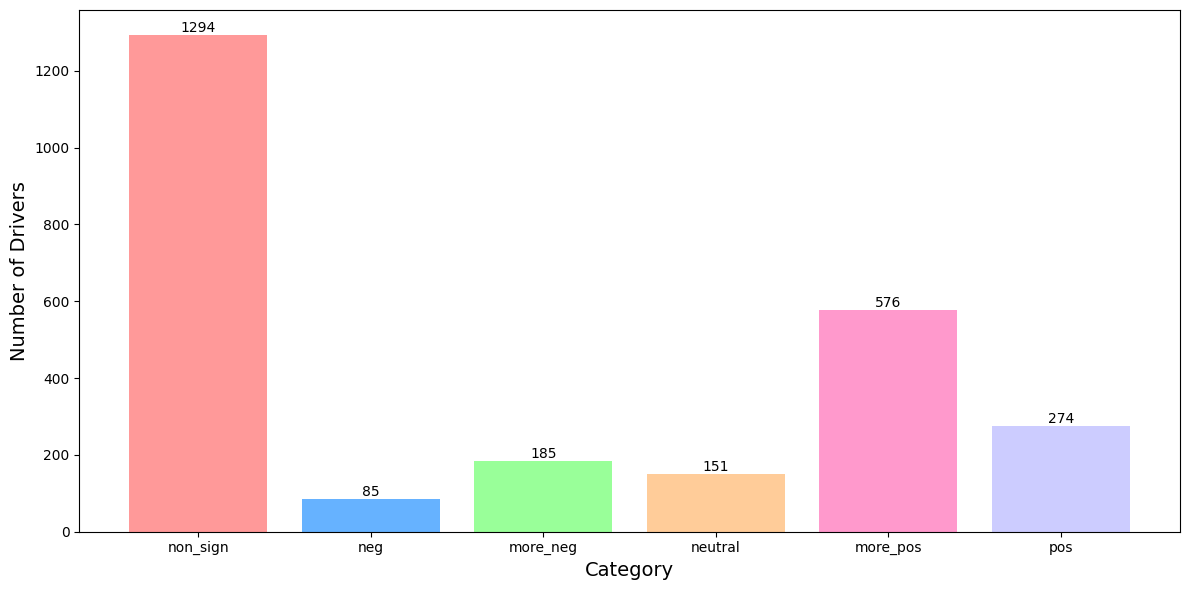


Total number of drivers: 2565


In [18]:
# Count the number of drivers in each category from the 'group' column
category_counts = driver_stats['group'].value_counts()
category_order = ['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']
category_counts = category_counts.reindex(category_order).fillna(0)

# Define colors for each category
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#CCCCFF'] 

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(category_counts.index, category_counts.values, color=colors)

# Customize the plot
#plt.title('Distribution of Drivers Across Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Drivers', fontsize=14)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Add category descriptions
category_descriptions = {
    'non_sign': 'Not Significant',
    'neg': 'Only Negative (Y-axis)',
    'pos': 'Only Positive (X-axis)',
    'more_pos': 'More Positive (Below y=x)',
    'more_neg': 'More Negative (Above y=x)',
    'neutral': 'Equal Positive and Negative'
}

# Add the descriptions to the plot
#plt.text(1.05, 0.5, '\n'.join([f"{k}: {v}" for k, v in category_descriptions.items()]), 
#         transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Print the total number of drivers
total_drivers = len(driver_stats)
print(f"\nTotal number of drivers: {total_drivers}")


The largest group consists of nonsignificant drivers, whereas the smallest group includes those with only negative associations.

The graphic below shows the distribution of positive and negative neighbours for each driver gene. Each driver is categorised according to the proportion of positive and negative neighbours. The dashed line represents equal proportions of positive and negative neighbours (y = x), allowing for a clear distinction between drivers with predominantly positive or negative correlations. The clustering of points near the origin represents drivers with a lower overall number of significant interactions, while the spread of points along the x and y axes highlights those drivers with more pronounced positive or negative associations.

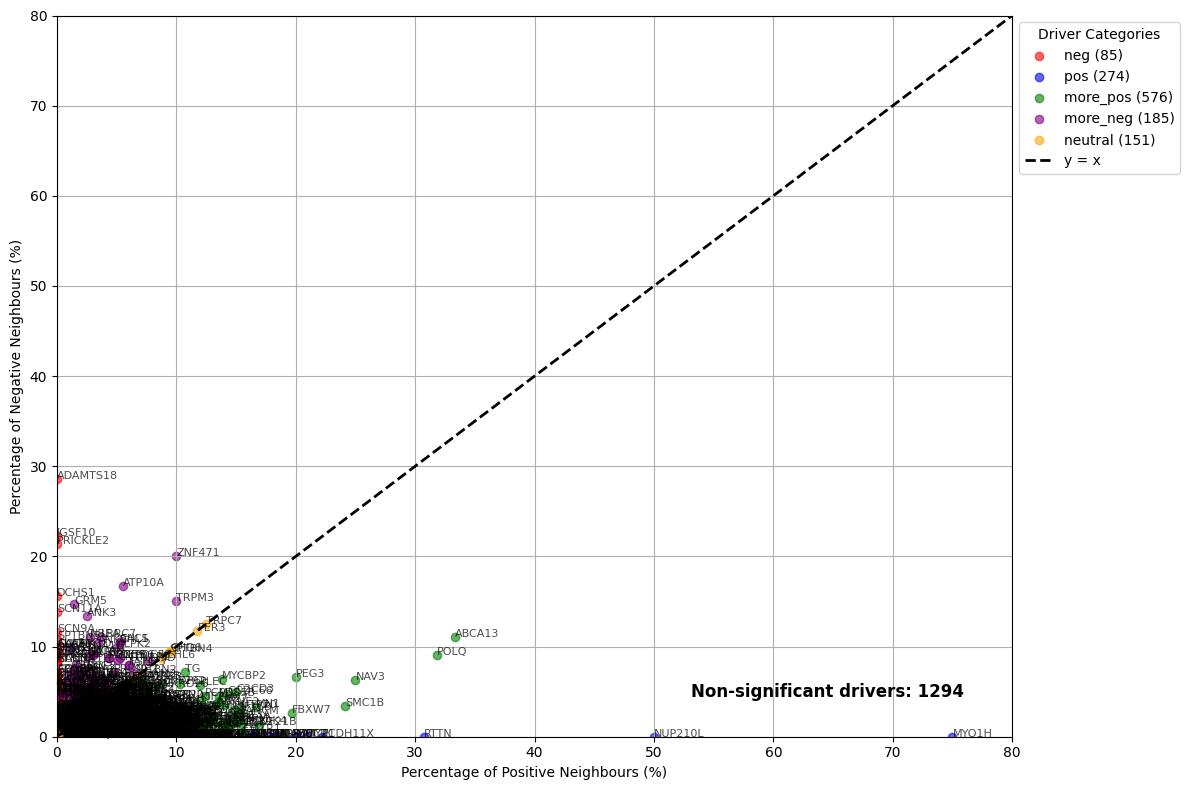

In [19]:
# Filter out non-significant drivers from the scatter plot data
filtered_driver_stats = driver_stats[driver_stats['group'] != "non_sign"]

# Count the non-significant drivers
non_significant_count = len(driver_stats[driver_stats['group'] == "non_sign"])

# Create the plot
plt.figure(figsize=(12, 8))

# Define colors for each category based on the 'group' column
color_map = {
    "neg": "red",
    "pos": "blue",
    "more_pos": "green",
    "more_neg": "purple",
    "neutral": "orange"
}

# Plot data points for each category excluding "non_sign"
for category, color in color_map.items():
    category_data = filtered_driver_stats[filtered_driver_stats['group'] == category]
    plt.scatter(
        category_data["pos_pct"] * 100,  # Convert percentages to 0-100 scale
        category_data["neg_pct"] * 100,  # Convert percentages to 0-100 scale
        color=color,
        alpha=0.6,
        label=f"{category} ({len(category_data)})"
    )

# Set x and y axis limits to 80
plt.xlim(0, 80)  # Set the x-axis limit to 80
plt.ylim(0, 80)  # Set the y-axis limit to 80

# Add y=x line for reference
plt.plot([0, 80], [0, 80], 'k--', lw=2, label="y = x")

# Add labels and title
plt.xlabel("Percentage of Positive Neighbours (%)")
plt.ylabel("Percentage of Negative Neighbours (%)")
#plt.title("Distribution of Positive and Negative Neighbours per Driver Gene")
plt.grid(True)

# Annotate drivers
for index, row in filtered_driver_stats.iterrows():
    plt.annotate(
        row['driver'],  # Use driver name for annotation
        (row["pos_pct"] * 100, row["neg_pct"] * 100),
        fontsize=8,
        alpha=0.7
    )

# Add a legend
plt.legend(title="Driver Categories", loc="upper left", bbox_to_anchor=(1, 1))

# Add non-significant driver count to the plot as a text annotation
plt.text(0.95, 0.05, f"Non-significant drivers: {non_significant_count}", 
         horizontalalignment='right', verticalalignment='bottom', 
         transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Our aim was to investigate whether drivers in these categories exhibit specific properties or behaviours, and how these properties might relate to the balance between positive and negative associations with neighbour gene abundances.

The first property analysed was the change in driver expression associated with mutations. For each driver, we compared the average expression between individuals with and without mutations in that driver. Based on this difference, we classified drivers into two groups: those that tend to show lower expression when mutated and those that tend to show higher expression when mutated.

In [20]:
# Filter only drivers that exist in both mutationtab and driver_tumour_expression
common_drivers = driver_stats['driver'][driver_stats['driver'].isin(mutationtab.columns) & driver_stats['driver'].isin(driver_tumour_expression.columns)]

# Apply expression analysis to filtered common drivers
exp_results = [analyze_driver_expression(driver, mutationtab, driver_tumour_expression, driver_stats) for driver in common_drivers]
results_df = pd.DataFrame([r for r in exp_results if r is not None])

# Analysis and visualizations
print(results_df)

category_summary = results_df.groupby('category').agg({
    'mean_expression_mutated': ['mean', 'std'],
    'mean_expression_non_mutated': ['mean', 'std'],
    'p_value': ['mean', 'median'],
    'driver': 'count'
}).rename(columns={'driver': 'count'})

print("\nStatistical summary by category:")
print(category_summary)

# Proportion of Expression Trends by Category
expression_trends = results_df.groupby('category')['expression_trend'].value_counts(normalize=True).unstack()
print("\nProportion of expression trends by category:")
print(expression_trends)

      driver  category  mean_expression_mutated  mean_expression_non_mutated  \
0       A1CF  non_sign                 1.364054                     1.733682   
1      A2ML1  more_pos                 3.792646                     3.984380   
2     ABCA10  non_sign                 3.434216                     3.776301   
3     ABCA13  more_pos                 4.416936                     4.238564   
4      ABCA7  non_sign                 8.592880                     8.488046   
...      ...       ...                      ...                          ...   
2462  ZSWIM3  non_sign                 6.757654                     6.826901   
2463  ZSWIM6  non_sign                 8.376133                     8.574214   
2464  ZWILCH  non_sign                 8.974727                     8.440610   
2465   ZWINT       pos                 9.697200                     8.939950   
2466   ZZEF1  more_pos                10.118257                    10.136499   

      mann_whitney_statistic   p_value 

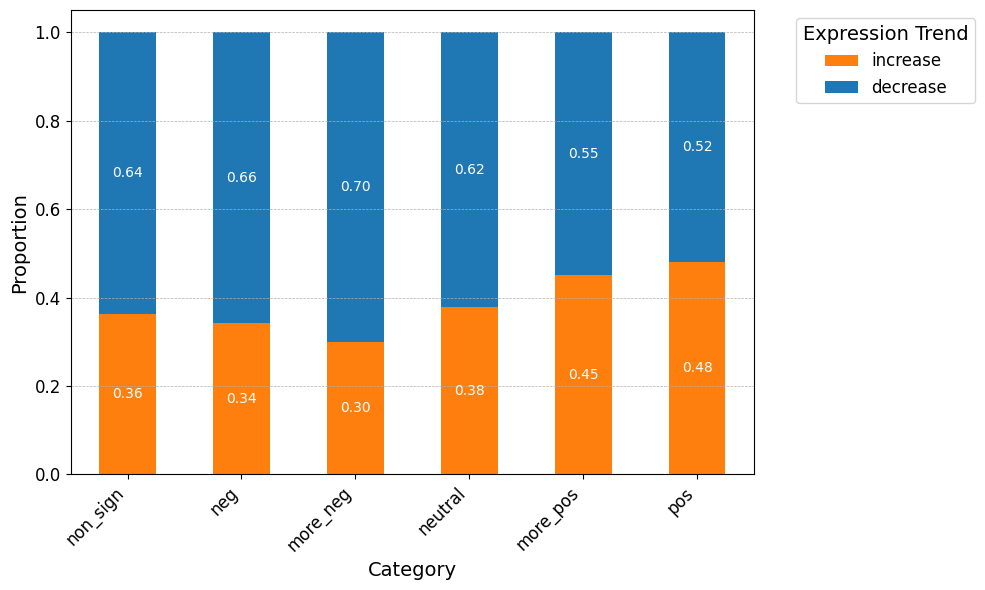

In [21]:
# Plotting the bar plot with custom colors for 'increase' and 'decrease' expression trends
# Define the colors for 'increase' and 'decrease'
colors = {'increase': '#ff7f0e', 'decrease': '#1f77b4'}

# Map the colors to the trends in the expression_trends dataframe
expression_trends = expression_trends[['increase', 'decrease']] 

# Reindex the dataframe based on the desired order in 'category_order'
expression_trends = expression_trends.reindex(category_order)

# Create the stacked bar chart with custom colors
ax = expression_trends.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=[colors[col] for col in expression_trends.columns])

# Customize the plot
#plt.title('Proportion of Expression Trends by Driver Category', fontsize=16)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Category', fontsize=14)

# Adjust the x-axis category labels to match the desired style
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and align x-axis labels

plt.yticks(fontsize=12)

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}', 
                ha='center', va='center', fontsize=10, color='white')

# Move the legend closer
plt.legend(title='Expression Trend', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Adjust the layout to ensure nothing overlaps
plt.tight_layout()

# Show the plot
plt.show()

Across all categories, a general trend towards decreased expression in mutated samples was observed. However, the pos and more_pos categories, which consist of drivers with predominantly positive neighbours, showed a more balanced distribution between increased and decreased expression upon mutation

In [22]:
# Create a contingency table for categories and expression trends
contingency_table = pd.crosstab(results_df['category'], results_df['expression_trend'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi-Square Test Results:
Chi-Square Statistic: 28.9563
P-value: 2.37e-05
Degrees of Freedom: 5

Contingency Table:
expression_trend  decrease  increase
category                            
more_neg               129        55
more_pos               307       251
neg                     54        28
neutral                 92        56
non_sign               787       446
pos                    136       126

Expected Values:
expression_trend    decrease    increase
category                                
more_neg          112.249696   71.750304
more_pos          340.409404  217.590596
neg                50.024321   31.975679
neutral            90.287799   57.712201
non_sign          752.194974  480.805026
pos               159.833806  102.166194


A chi-squared test confirmed that the higher proportion of drivers that increase expression when mutated in the pos and more_pos categories is significant (p-value = $2.37 \times 10^{-05}$).

### Classification of drivers as canonical or candidate

We further divided the drivers into canonical (well-established cancer drivers) and candidate (potential or less-characterised cancer drivers) based on their annotations in NCG<sup>HD</sup>.

In [23]:
# Call the function and unpack the returned values
counts, percentages, chi2, p_value, expected, total_canonical, total_candidate = analyze_driver_distribution(
    driver_stats, cancerdrivers, category_order
)

In [24]:
# Print results
print(f"\nTotal Canonical Drivers: {total_canonical}")
print(f"Total Candidate Drivers: {total_candidate}")


Total Canonical Drivers: 476
Total Candidate Drivers: 2089


Out of the 2565 cancer driver genes studied, 2089 are classified as candidate drivers, while 476 are classified as canonical drivers.

In [25]:
# Print results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print("\nExpected Frequencies (Under Null Hypothesis):")
print(expected)
print("\nDriver counts by category:")
print(counts)
print("\nPercentage of drivers by category:")
print(percentages)


Chi-Square Test Results:
Chi-Square Statistic: 153.0727
P-value: 2.96e-31

Expected Frequencies (Under Null Hypothesis):
driver_type    Candidate   Canonical
group                               
more_neg      150.668616   34.331384
more_pos      469.108772  106.891228
neg            69.226121   15.773879
neutral       122.978168   28.021832
non_sign     1053.865887  240.134113
pos           223.152437   50.847563

Driver counts by category:
driver_type  Candidate  Canonical
group                            
non_sign          1164        130
neg                 66         19
more_neg           122         63
neutral            118         33
more_pos           397        179
pos                222         52

Percentage of drivers by category:
driver_type  Candidate  Canonical
group                            
non_sign     89.953632  10.046368
neg          77.647059  22.352941
more_neg     65.945946  34.054054
neutral      78.145695  21.854305
more_pos     68.923611  31.076389
pos     

To assess whether the differences in the proportions of canonical and candidate drivers across the six categories are statistically significant, a chi-squared test was performed. The p-value obtained from the test was $2.96 \times 10^{-31}$, indicating a highly significant association between driver type (canonical vs. candidate) and the driver-neighbour categories. This confirms that the distribution of canonical and candidate drivers is non-random, with canonical drivers being more likely to exhibit significant interactions with their neighbours.

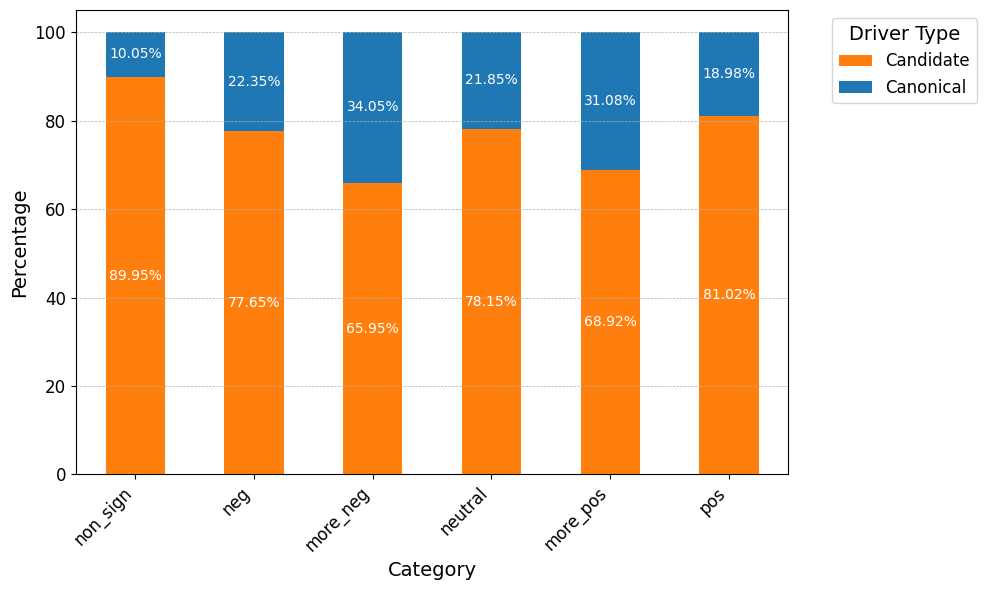

In [26]:
# Create visualization
fig, ax = plot_driver_distribution(percentages)
plt.show()

As shown in the graphic above, the non_sign category has the lowest proportion of canonical drivers, with only 10.05% classified as such. This category represents drivers that do not show significant correlations with neighbouring genes. The enrichment of candidate drivers in this group (89.95%) suggests that it may contain proteins that are not real drivers, and that having associations with neighbour abundance is characteristic of genuine cancer drivers.

The higher proportion of candidate drivers in the non_sign category, combined with the greater presence of canonical drivers in categories with more significant driver-neighbour associations, supports the idea that well-characterised cancer drivers tend to have significant associations with their neighbouring genes. The more_neg category, for example, shows the highest proportion of canonical drivers at 34.05%.

Overall, across all categories, candidate drivers outnumber canonical drivers, indicating that many genes involved in cancer processes are still not fully characterised. Categories such as pos (with 81.02% candidate drivers) and neutral (with 78.15% candidate drivers) highlight the potential for discovering new cancer-related mechanisms among these less characterised genes.

### Oncogenes vs. Tumour suppressor genes

We further analysed the distribution of driver genes classified as tumour suppressors (TSGs) and oncogenes (OGs) based on their annotations in NCG<sup>HD</sup>.

In [27]:
# Split drivers into oncogenes and tumor suppressors
oncogenes = list(set(cancerdrivers[cancerdrivers['NCG_oncogene'] == 1]['symbol']))
tumor_suppressors = list(set(cancerdrivers[cancerdrivers['NCG_tsg'] == 1]['symbol']))

# Classify the drivers
results_df['driver_type'] = results_df['driver'].apply(lambda x: 'Oncogene' if x in oncogenes else ('Tumour Suppressor' if x in tumor_suppressors else 'Unknown'))
print("\nDriver types:")
print(results_df['driver_type'].value_counts())


Driver types:
driver_type
Unknown              2076
Tumour Suppressor     206
Oncogene              185
Name: count, dtype: int64


Specifically, we examined how 206 tumour suppressor genes and 185 oncogenes are distributed across six driver-neighbour significant association categories, as previously defined.

In [28]:
results_df_not_unk = results_df[results_df['driver_type'] != 'Unknown']

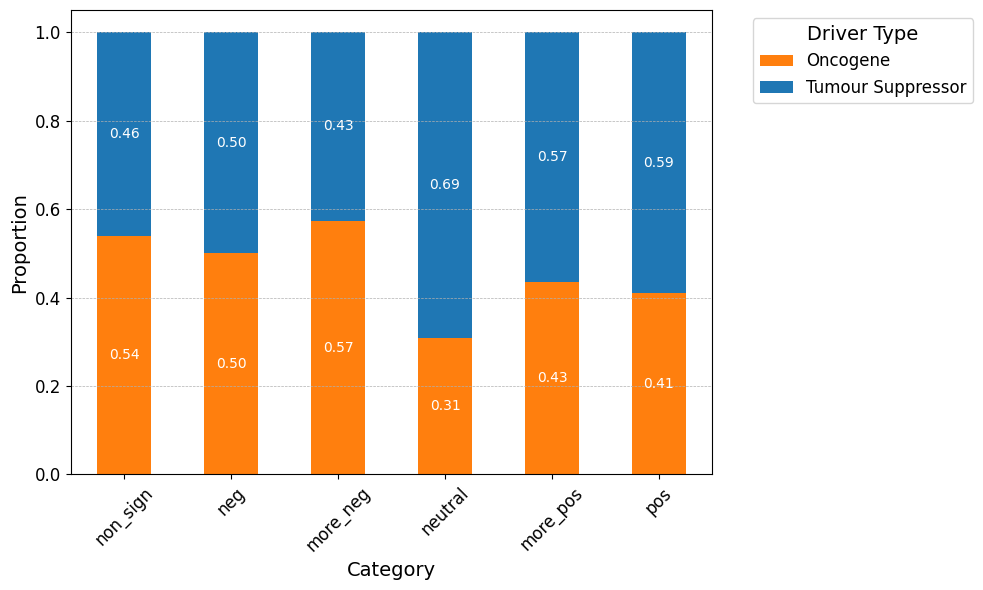

In [29]:
# Create a crosstab with categories on the x-axis and driver types as proportions
category_by_type = pd.crosstab(results_df_not_unk['category'], results_df_not_unk['driver_type'], normalize='index')

# Reorder the categories according to the desired order
category_by_type = category_by_type.reindex(category_order)

# Define colors for Oncogene (orange), Tumor Suppressor (blue), and Unknown (gray)
colors = {
    'Oncogene': '#ff7f0e',  # Orange for Oncogene
    'Tumour Suppressor': '#1f77b4',  # Blue for Tumor Suppressor
    'Unknown': '#d3d3d3'  # Gray for Unknown
}

# Create the stacked bar chart with wider bars
ax = category_by_type.plot(kind='bar', stacked=True, figsize=(10, 6),
                           color=[colors[col] for col in category_by_type.columns])

# Customize the plot
#plt.title('Driver Type by Category', fontsize=16)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Category', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add values inside each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2., f'{height:.2f}', 
                ha='center', va='center', fontsize=10, color='white')

# Move the legend closer
plt.legend(title='Driver Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

The analysis revealed that all categories contain a mix of tumour suppressors and oncogenes, though their distributions differ significantly.

TSGs are more prevalent in the neutral, pos, and more_pos categories, where they show predominantly positive associations with neighbouring genes. In contrast, OGs are more commonly associated with the neg, more_neg, and non_sign categories, which exhibit negative or non-significant associations with neighbours.

To assess the statistical significance of these observed distribution patterns, we conducted two chisquared tests.

In [30]:
contingency_table = pd.crosstab(results_df_not_unk['category'], results_df_not_unk['driver_type'])

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the test results
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of Freedom: {dof}")

print("\nContingency Table:")
print(contingency_table)

print("\nExpected Values (Under Null Hypothesis):")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi-Square Test Results:
Chi-Square Statistic: 8.4312
P-value: 1.34e-01
Degrees of Freedom: 5

Contingency Table:
driver_type  Oncogene  Tumour Suppressor
category                                
more_neg           31                 23
more_pos           66                 86
neg                 8                  8
neutral             8                 18
non_sign           56                 48
pos                16                 23

Expected Values (Under Null Hypothesis):
driver_type   Oncogene  Tumour Suppressor
category                                 
more_neg     25.549872          28.450128
more_pos     71.918159          80.081841
neg           7.570332           8.429668
neutral      12.301790          13.698210
non_sign     49.207161          54.792839
pos          18.452685          20.547315


The first test, based on the original six categories, yielded a chi-squared statistic of 8.43 with a p-value of 0.134, indicating that the differences in TSG and OG distributions across the categories were not statistically significant at conventional levels. This suggests that the variation in TSG and OG distributions may be due to random chance.

However, we also performed a second test after merging similar categories: pos and more_pos into a ’positive’ category, and neg and more_neg into a ’negative’ category.

In [31]:
df_not_unk = results_df_not_unk.copy()

# Apply the function to create the merged category column
df_not_unk['merged_category'] = df_not_unk['category'].apply(merge_categories)

# Create a contingency table (cross-tabulation) of the driver types and merged categories
contingency_table_merged = pd.crosstab(df_not_unk['driver_type'], df_not_unk['merged_category'])

# Perform the chi-square test on the merged categories
chi2_stat_merged, p_val_merged, dof_merged, expected_merged = chi2_contingency(contingency_table_merged)

# Print the results
print(f"Chi-Square Test (Merged Categories):")
print(f"Chi-Square Statistic: {chi2_stat_merged}, P-value: {p_val_merged}")

Chi-Square Test (Merged Categories):
Chi-Square Statistic: 8.088031572371024, P-value: 0.044226965730473335


This test yielded a chi-squared statistic of 8.09 and a p-value of 0.044, suggesting a statistically significant difference in the distributions of TSGs and OGs across these broader categories.

The difference between the two chi-squared tests can be explained by how the categories were grouped and the statistical power that resulted from these groupings. In the original test with six distinct categories, each one contained fewer data points, reducing the statistical power of the test. As a result, the test was unable to detect a statistically significant difference.

In the second test, by merging similar categories (i.e., pos with more_pos and neg with more_neg), we increased the number of observations in each group, thus enhancing the statistical power of the chi-squared test. This aggregation allowed the test to detect a significant difference between the TSG and OG distributions, as reflected by the p-value of 0.044. The broader categorisation still captures the key biological distinctions between positive and negative associations, and by consolidating the data into
fewer categories, the test became more sensitive to underlying differences in how TSGs and OGs interact with their neighbouring genes.

## Functional encrichment analysis

To further characterise the six driver categories, we sought to determine whether each category exhibited a unique functional signature and how these signatures related to known cancer hallmarks.

In [32]:
hallmarks_df = pd.read_excel('hallmarks_to_goterms.xlsx')
hallmarks_df['Hallmarks'] = hallmarks_df['Hallmarks'].str.strip()
hallmarks_df['GO terms'] = hallmarks_df['GO terms'].str.strip()
hallmarks_df['Term name'] = hallmarks_df['Term name'].str.strip()

In [33]:
background = []
for net in networks:
    ppi = pd.read_csv(datadir + f"{net}_graph.csv")
    # Extract unique proteins from both columns of the PPI network
    gene_names = pd.concat([ppi.iloc[:, 0], ppi.iloc[:, 1]]).drop_duplicates().tolist()
    background.extend(gene_names)

# Remove duplicates to get the final background set
background = list(set(background))

print(f'Total number of unique proteins in background: {len(background)}')

Total number of unique proteins in background: 20142


### Separated groups

We began by performing for each driver category separately a functional enrichment analysis using the g:Profiler tool, applying functional annotation sources such as Gene Ontology: Molecular Function (GO:MF), Gene Ontology: Cellular Component (GO:CC), GO:BP, KEGG, REAC, and WikiPathways (WP).

In [34]:
sources = ["GO:MF", "GO:CC", "GO:BP", "KEGG", "REAC", "WP"]

In [35]:
# Configure GProfiler
gp = GProfiler(return_dataframe=True)

drivers_group_by_classification = {
    category: driver_stats[driver_stats['group'] == category]['driver'].tolist()
    for category in ['non_sign', 'neg', 'pos', 'more_pos', 'more_neg', 'neutral']
}

# Perform enrichment analysis
results_separated = {}
for classification, drivers_list in drivers_group_by_classification.items():
    results_separated[classification] = {}
    for source in sources:
        try:
            results_separated[classification][source] = gp.profile(
                organism='hsapiens',
                query=drivers_list,
                user_threshold=0.05,
                no_evidences=False,
                sources=[source],
                all_results=False,
                domain_scope='annotated',
                background=background,
                significance_threshold_method='fdr'
            )
        except Exception as e:
            print(f"Error in group {classification}, source {source}: {str(e)}")
            results_separated[classification][source] = pd.DataFrame()  # Empty DataFrame if error occurs

In [36]:
# Consolidate results in single terms per group
consolidated_terms = {}
for group, source_results in results_separated.items():
    df_list = [df[['source', 'name', 'intersection_size', 'query_size', 'term_size', 'effective_domain_size']] for df in source_results.values()]
    consolidated_df = pd.concat(df_list).drop_duplicates(subset='name')
    consolidated_terms[group] = consolidated_df

In [37]:
# Identify exclusive functions by group
exclusive_functions_by_group = {}
for group, terms_df in consolidated_terms.items():
    all_functions = set(terms_df['name'])
    unique_functions = all_functions.copy()
    for other_group, other_terms_df in consolidated_terms.items():
        if group != other_group:
            other_functions = set(other_terms_df['name'])
            unique_functions.difference_update(other_functions)
    exclusive_functions_by_group[group] = unique_functions

# Calculate fold enrichment for exclusive functions
dfs_by_group = {}
for group, unique_functions in exclusive_functions_by_group.items():
    dfs_temp = []
    terms_df = consolidated_terms[group]
    exclusive_functions_in_df = terms_df[terms_df['name'].isin(unique_functions)]
    for index, row in exclusive_functions_in_df.iterrows():
        intersection_size = row['intersection_size']
        query_size = row['query_size']
        term_size = row['term_size']
        effective_domain_size = row['effective_domain_size']
        fold_enrichment = (intersection_size / query_size) / (term_size / effective_domain_size)
        df_temp = pd.DataFrame({'Term_name': [row['name']], 'Fold_Enrichment': [fold_enrichment], 'Source': [row['source']]})
        dfs_temp.append(df_temp)
    
    if dfs_temp:  # Check if there are any DataFrames to concatenate
        df_group = pd.concat(dfs_temp, ignore_index=True)
        df_group = df_group.sort_values(by='Fold_Enrichment', ascending=False)
        dfs_by_group[group] = df_group
    else:
        print(f"No exclusive functions with fold enrichment data for group {group}")

# Print results
for group, df_group in dfs_by_group.items():
    print(f"\nDataFrame for group {group}:")
    print(df_group)


DataFrame for group non_sign:
                                            Term_name  Fold_Enrichment Source
43  positive regulation of serine-type peptidase a...        15.771739  GO:BP
42  positive regulation of serine-type endopeptida...        15.771739  GO:BP
58       regulation of serine-type peptidase activity        11.828804  GO:BP
54  negative regulation of mesenchymal cell apopto...        11.828804  GO:BP
19                      decanoate-CoA ligase activity        11.828804  GO:MF
..                                                ...              ...    ...
48  adenylate cyclase-modulating G protein-coupled...         1.890002  GO:BP
21  secondary active transmembrane transporter act...         1.777905  GO:MF
24                   external side of plasma membrane         1.738283  GO:CC
85            Neuroactive ligand-receptor interaction         1.708605   KEGG
72       G protein-coupled receptor signaling pathway         1.349767  GO:BP

[103 rows x 3 columns]

DataFram

Our findings revealed that all six driver categories were enriched in exclusive annotation terms. Despite having the largest number of drivers, the non_sign category had relatively few exclusive enriched terms compared to the categories with significant driver-neighbour associations.

### All Groups

The presence of exclusive enriched terms highlights unique functional associations within each driver category. However, a functional annotation can exist across multiple categories, and its representation may not be proportional to the size of each category. Therefore, we expanded our analysis to include all drivers, calculating the frequency of each enriched term within each category.

In [38]:
driver_stats = driver_stats.set_index('driver')

In [39]:
# Initialize GProfiler
gp = GProfiler(return_dataframe=True)
all_drivers = driver_stats.index.tolist()
driver_category_map = driver_stats['group'].to_dict()

# Create a wrapper function for ThreadPoolExecutor
def process_source_wrapper(source):
    """Wrapper function to handle the source parameter for ThreadPoolExecutor"""
    return process_source(source, gp, all_drivers, driver_category_map, background)

# Process sources using ThreadPoolExecutor
results_df = []
with ThreadPoolExecutor(max_workers=len(sources)) as executor:
    # Map the function to sources
    future_results = list(executor.map(process_source_wrapper, sources))
    
    # Collect results
    results_df = [df for df in future_results if not df.empty]

# Combine all results
if results_df:
    final_results_df = pd.concat(results_df, ignore_index=True)
    display(final_results_df)
else:
    print("No results found for any source.")

,Source,Name,FE,native,intersections,description,non_sign,neg,more_neg,more_pos,pos,neutral
0,GO:MF,molecular_function,1.115832,GO:0003674,"[A1CF, A2ML1, ABCA10, ABCA13, ABCA7, ABCB1, AB...","""A molecular process that can be carried out b...",1243,85,182,571,269,148
1,GO:MF,binding,1.142440,GO:0005488,"[A1CF, ABCA10, ABCA13, ABCA7, ABCB1, ABCB5, AB...","""The selective, non-covalent, often stoichiome...",1136,80,178,569,265,145
2,GO:MF,organic cyclic compound binding,1.496092,GO:0097159,"[A1CF, ABCA10, ABCA13, ABCA7, ABCB1, ABCB5, AB...","""Binding to an organic cyclic compound, any mo...",450,23,85,349,157,64
3,GO:MF,ion binding,1.463665,GO:0043167,"[ABCA10, ABCA13, ABCA7, ABCB1, ABCB5, ABCC3, A...","""Binding to an ion, a charged atoms or groups ...",483,37,98,287,121,77
4,GO:MF,small molecule binding,1.431691,GO:0036094,"[ABCA10, ABCA13, ABCA7, ABCB1, ABCB5, ABCC3, A...","""Binding to a small molecule, any low molecula...",490,38,98,289,123,77
...,...,...,...,...,...,...,...,...,...,...,...,...
4616,WP,Clock controlled autophagy in bone metabolism,1.694162,WP:WP5205,"[AKT1, ARHGAP4, ATG3, ATG7, BCL2, BMP5, BMPR2,...",Clock controlled autophagy in bone metabolism,8,0,1,7,1,0
4617,WP,Prostaglandin and leukotriene metabolism in se...,2.110375,WP:WP5321,"[ADCY3, ALOX12, CDKN1A, GNAQ, GNAS, HRAS, LTA4...",Prostaglandin and leukotriene metabolism in se...,4,1,3,1,0,0
4618,WP,10q11 21q11 23 copy number variation syndrome,1.818296,WP:WP5352,"[BCL2, CDH1, DEK, ERCC5, ERCC6, FRMPD2, GDF5, ...",10q11 21q11 23 copy number variation syndrome,7,0,1,2,3,0
4619,WP,RAS and bradykinin pathways in COVID 19,2.199318,WP:WP4969,"[ACE, AGTR2, KLK1, MAPK1, NOS1, PRKG1, RHOA, S...",RAS and bradykinin pathways in COVID 19,5,0,1,2,0,0


In [41]:
final_results_df['Source'].value_counts()

Source
GO:BP    2800
REAC      607
GO:MF     385
WP        366
GO:CC     271
KEGG      192
Name: count, dtype: int64

In [42]:
final_results_df.to_csv(datadir + 'enrichment_results.csv', index=False)

We also examined the proportion of drivers in each category annotated with GO terms related to cancer hallmarks, based on the consensus published by Chen et al. (Chen, Verbeek, & Wolstencroft, 2021).

References
- Chen, Y., Verbeek, F. J., & Wolstencroft, K. Establishing a consensus for the hallmarks of cancer based on gene ontology and pathway annotations. *BMC Bioinformatics*, 22, 178 (2021). https://doi.org/10.1186/s12859-021-04105-8

In [43]:
all_intersections_set_drivers = set()

for source in sources:
    if source.startswith('GO:BP'):
        dic = final_results_df[final_results_df['Source'] == source]
        dic_filt_drivers = pd.merge(dic, hallmarks_df[['GO terms', 'Term name', 'Hallmarks']], 
                                left_on='native', right_on='GO terms', how='inner')
        
        # Extracts the values from the ‘intersections’ column and adds them to the all_intersections_set set
        for intersection_list in dic_filt_drivers['intersections']:
            all_intersections_set_drivers.update(intersection_list)

count_only_drivers_in_intersections = sum(1 for item in all_drivers if item in all_intersections_set_drivers)

print(f"Number of all_drivers values that appear in the intersections: {count_only_drivers_in_intersections}")
proportion = count_only_drivers_in_intersections / len(all_drivers) 
print(f"Proportion of values that appear at the intersections: {proportion}")

Number of all_drivers values that appear in the intersections: 1436
Proportion of values that appear at the intersections: 0.5598440545808967


By extracting all drivers appearing in the intersections of these GO terms, we found that 1436 out of 2565 unique drivers (56%) were associated with hallmarks of cancer. This high coverage of drivers associated with hallmark-related GO terms indicates that our analysis is capturing drivers likely to be functionally important in cancer-related processes. The remaining drivers, which were not annotated with hallmark-related terms, might represent novel or less well-characterised driver genes that could be of interest for further investigation.

In [44]:
hallmark_drivers = set(all_intersections_set_drivers)

In [45]:
# Create dictionaries to store counts for each category
category_counts = {cat: 0 for cat in category_order}
hallmark_category_counts = {cat: 0 for cat in category_order}

# Count the drivers in each category and the hallmark drivers
for driver in driver_stats.index:
    category = driver_stats.loc[driver, 'group']
    if pd.notna(category):
        category_counts[category] += 1
        if driver in hallmark_drivers:
            hallmark_category_counts[category] += 1

# Calculate proportions
proportions = {}
for category in category_counts.keys():
    total = category_counts[category]
    hallmark = hallmark_category_counts[category]
    proportion = hallmark / total if total > 0 else 0
    proportions[category] = proportion

# Print results
print("Proportion of hallmark-related drivers in each category:")
for category, proportion in proportions.items():
    print(f"{category}: {proportion:.2%} ({hallmark_category_counts[category]} of {category_counts[category]})")

Proportion of hallmark-related drivers in each category:
non_sign: 45.75% (592 of 1294)
neg: 65.88% (56 of 85)
more_neg: 72.43% (134 of 185)
neutral: 64.24% (97 of 151)
more_pos: 68.58% (395 of 576)
pos: 59.12% (162 of 274)


The non_sign category again stood out, with only 45.75% of its drivers associated with hallmark-related GO terms. In contrast, drivers in categories with significant driver-neighbour associations showed proportions close to 60% or higher of hallmark-associated drivers.